# HMS - PyTorch Baseline Training

**Comments welcome!**

One of my goals in this competition is to learn more PyTorch.

This is a **training** notebook; the respective inference notebook is [HMS - PyTorch Baseline Inference](https://www.kaggle.com/code/morodertobias/hms-pytorch-baseline-inference) and the saved models are uploaded as a dataset [HMS - PyTorch Baseline Training Dataset](https://www.kaggle.com/datasets/morodertobias/hms-pytorch-baseline-training-dataset) to keep versions clean.

Current version fine-tunes EfficientNetB0 from noisy student weights in a 5-folding manner. It uses squashed spectrograms, as already done in the reference notebooks. I try to use my way of coding, but naturally it is similar.

This is just a quick-saved with additional comments, the last successful run with the weights stored in the dataset is: [Verison 3](https://www.kaggle.com/code/morodertobias/hms-pytorch-baseline-training?scriptVersionId=161574160).

## References
- [HMS baseline_resnet34d(512*512 Training 5 folds)](https://www.kaggle.com/code/yunsuxiaozi/hms-baseline-resnet34d-512-512-training-5-folds)
- [HMS: Train EfficientNetB0](https://www.kaggle.com/code/andreasbis/hms-train-efficientnetb0/notebook)
- [HMS-HBAC: ResNet34d Baseline [Training]](https://www.kaggle.com/code/ttahara/hms-hbac-resnet34d-baseline-training/)


## Table of Contents
- [Imports](#Imports)
- [Config](#Config)
- [Load data](#Load-data)
- [Data Handling](#Data-Handling)
- [Model](#Model)
- [Training Utils](#Training-Utils)
- [Training](#Training)
- [OOF](#OOF)

# Imports

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm

# Config

In [2]:
class CFG:
    seed = 888
    debug = False
    one_fold = False
    base_dir = pathlib.Path("/kaggle/input/hms-harmful-brain-activity-classification")
    path_train = base_dir / "train.csv"
    spec_dir = base_dir / "train_spectrograms"
    transform = transforms.Resize((512, 512), antialias=False)
    model_name = "tf_efficientnet_b0_ns"
    n_fold = 5
    epochs = 10
    batch_size = 16    
    lr = 0.001

# Load data
- We classify the spectrogram directly.
- As a label we use the aggregated the votes per spectrogram slice

In [3]:
train_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
train_df

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [4]:
label_columns = train_df.filter(like="_vote").columns.to_list()
label_columns

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [5]:
#data frame을 spectrogram_id column으로 묶고, label_columns에 해당하는 columns들의 값을 spectrogram id에 따라 합한다.
data = train_df.groupby("spectrogram_id")[label_columns].sum()
data

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
spectrogram_id,,,,,,
353733,27,0,0,0,0,0
924234,0,0,10,0,2,10
999431,0,11,0,154,0,11
1084844,0,0,0,18,0,0
1219001,21,0,10,0,0,0
...,...,...,...,...,...,...
2146188334,0,0,0,0,0,39
2146414988,0,1,0,0,0,0
2146798838,0,36,0,8,0,28


In [6]:
n = data.sum(axis=1) # 각 spectrogram id의 개수를 나타낸다. 
n

spectrogram_id
353733         27
924234         22
999431        176
1084844        18
1219001        31
             ... 
2146188334     39
2146414988      1
2146798838     72
2147312808     15
2147388374     33
Length: 11138, dtype: int64

In [7]:
# label column에 해당하는 column을 전체 개수로 나눈다. 
for x in label_columns:
    data[x] = data[x] / n
# parquet의 path를 추가
data["path"] = data.index.map(lambda x: CFG.spec_dir / f"{x}.parquet")
data = data.reset_index()
data

,spectrogram_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,path
0,353733,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
1,924234,0.000000,0.0000,0.454545,0.000000,0.090909,0.454545,/kaggle/input/hms-harmful-brain-activity-class...
2,999431,0.000000,0.0625,0.000000,0.875000,0.000000,0.062500,/kaggle/input/hms-harmful-brain-activity-class...
3,1084844,0.000000,0.0000,0.000000,1.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
4,1219001,0.677419,0.0000,0.322581,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
...,...,...,...,...,...,...,...,...
11133,2146188334,0.000000,0.0000,0.000000,0.000000,0.000000,1.000000,/kaggle/input/hms-harmful-brain-activity-class...
11134,2146414988,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
11135,2146798838,0.000000,0.5000,0.000000,0.111111,0.000000,0.388889,/kaggle/input/hms-harmful-brain-activity-class...
11136,2147312808,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...


# Data Handling
- Spectrogram is loaded, which contains spectrograms in 4 different regions.
- All together they are clipped, log-transformed and the standardized.
- Finally it is resized as an image.
- Note, since the spectrograms have sometimes very different lenghts this creates a certain distortion.

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
#데이터 전처리 과정
def preprocess(x):
    # np.clip(데이터, 하한값, 상한값)인데, 데이터를 하한~상한값으로 잘라 극단적인 값을 없앰
    x = np.clip(x, np.exp(-6), np.exp(10)) 
    x = np.log(x)# 데이터를 로그 스케일로 변환
    m, s = x.mean(), x.std()
    x = (x - m) / (s + 1e-6)#표준편차가 0이 되는 것을 방지
    return x


class SpecDataset(Dataset):
    
    def __init__(self, df, transform=CFG.transform):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index] # index번째 행을 불러옴
        # input
        x = pd.read_parquet(row.path)
        x = x.fillna(-1).values[:, 1:].T # 결측값을 -1로 채운 뒤, 0번째 배열을 제외한 모든 열을 선택, transpose
        x = preprocess(x)
        x = torch.Tensor(x[None, :]) # 차원을 추가 후 모든 열을 선택
        if self.transform: # transform이 있다면 수행
            x = self.transform(x)
        # output
        y = np.array(row.loc[label_columns].values, 'float32')
        y = torch.Tensor(y)
        return x, y

In [10]:
ds = SpecDataset(df=data.iloc[:50])
ds, len(ds)

(<__main__.SpecDataset at 0x7dabffedbca0>, 50)

In [11]:
x, y = ds[0]
x.shape, x, y.shape, y

(torch.Size([1, 512, 512]),
 tensor([[[ 1.2054,  1.0713,  0.9173,  ...,  1.0850,  1.0003,  0.9526],
          [ 1.6161,  1.3790,  1.0838,  ...,  1.1306,  1.0802,  1.0625],
          [ 1.7601,  1.6410,  1.4847,  ...,  1.2272,  1.1640,  1.1396],
          ...,
          [-0.8010, -0.6403, -0.4212,  ..., -0.8658, -1.1458, -1.3737],
          [-0.7389, -0.5765, -0.3597,  ..., -0.8116, -1.2053, -1.5185],
          [-0.8025, -0.5923, -0.3145,  ..., -0.8211, -1.2874, -1.6645]]]),
 torch.Size([6]),
 tensor([1., 0., 0., 0., 0., 0.]))

In [12]:
ld = DataLoader(dataset=ds, batch_size=CFG.batch_size, drop_last=True, num_workers=os.cpu_count())
ld, len(ld)

(<torch.utils.data.dataloader.DataLoader at 0x7dabffeda800>, 3)

In [13]:
x, y = next(iter(ld))
x.shape, x, y.shape, y

(torch.Size([16, 1, 512, 512]),
 tensor([[[[ 1.2054,  1.0713,  0.9173,  ...,  1.0850,  1.0003,  0.9526],
           [ 1.6161,  1.3790,  1.0838,  ...,  1.1306,  1.0802,  1.0625],
           [ 1.7601,  1.6410,  1.4847,  ...,  1.2272,  1.1640,  1.1396],
           ...,
           [-0.8010, -0.6403, -0.4212,  ..., -0.8658, -1.1458, -1.3737],
           [-0.7389, -0.5765, -0.3597,  ..., -0.8116, -1.2053, -1.5185],
           [-0.8025, -0.5923, -0.3145,  ..., -0.8211, -1.2874, -1.6645]]],
 
 
         [[[ 1.8998,  1.8514,  1.7770,  ...,  1.5049,  1.6229,  1.6995],
           [ 1.9068,  1.8645,  1.7993,  ...,  1.5456,  1.6550,  1.7260],
           [ 1.9491,  1.8969,  1.8166,  ...,  1.5353,  1.6585,  1.7386],
           ...,
           [-0.9747, -0.9018, -0.7895,  ..., -1.1577, -1.2446, -1.3011],
           [-0.9120, -0.8630, -0.7876,  ..., -1.2038, -1.3935, -1.5167],
           [-0.7837, -0.7837, -0.7837,  ..., -1.0045, -1.5825, -1.9580]]],
 
 
         [[[ 1.1971,  1.0295,  0.7975,  ...,  1.

# Model

In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


In [15]:
# 할당된 메모리 양 확인
torch.cuda.memory_allocated()

0

In [16]:
# pretrained된 모델을 불러옴
model = timm.create_model(model_name=CFG.model_name, pretrained=True, num_classes=6, in_chans=1)
model.to(DEVICE)
num_parameter = sum(x.numel() for x in model.parameters())
print(f"Model has {num_parameter} parameters.")

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Model has 4014658 parameters.


In [17]:
y_out = model(x.to(DEVICE))
y_out

tensor([[ 0.2999, -4.0431, -0.5702,  0.1073, -3.0633, -2.4262],
        [-0.3760, -1.7042, -1.4584, -0.5718,  3.4008, -0.0498],
        [-5.0199, -0.7434, -1.3510,  0.7812,  0.1362, -0.6503],
        [-0.3046, -1.4623, -0.2989, -0.4120,  0.1605, -1.1544],
        [-0.5352, -0.4791, -0.1311,  0.6894,  1.4193,  0.7561],
        [-0.5000,  1.9279, -0.1230,  0.3023,  1.1977,  1.4002],
        [ 0.5245, -0.7269,  0.0982,  0.0063,  0.4017,  0.0906],
        [ 0.4476, -0.3200, -2.8000,  1.0312,  0.1529, -1.1858],
        [-1.0779, -2.2137, -1.0679,  0.4127,  0.9357, -0.4939],
        [-0.4356, -1.4117, -1.0345,  0.3104,  0.0214, -0.8664],
        [-4.2029,  0.1144, -1.0960,  2.0125, -0.0881, -0.3767],
        [-0.1313, -1.7955, -0.7537,  0.1534,  0.1826, -0.9321],
        [ 1.7528, -0.6548, -1.1638, -0.5216,  1.1650,  0.2021],
        [ 0.5694, -0.9056, -0.4122, -0.0230, -1.7966, -1.0683],
        [-0.7466,  0.5304,  0.3279, -0.1537, -0.9317,  0.3318],
        [-0.6858, -0.6658, -2.7490,  0.8

# Training Utils
- Create Kullback-Leibler Divergence loss from logits.
- Compute loss utility.

### KL-Divergence
- 두 분포가 얼마나 다른지 비교
- P: 실제 확률 분포, Q: 예측한 확률 분포

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fd6kB8E%2FbtqXrCVgLLY%2FUsC62uOertsM4hkvtJYqIK%2Fimg.png" width="50%">

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FDGr9U%2FbtqXwcCouUA%2FtLDjjqttMk1BUcbH9ajsD0%2Fimg.png" width="50%">

In [18]:
# 손실 함수 설정
# 활성화 함수: log softmax
def KLDivLoss(logit, target):
    log_prob = F.log_softmax(logit, dim=1) # 예측한 확률 값
    return F.kl_div(log_prob, target, reduction="batchmean")

In [19]:
# from reference
def KL_loss(p,q):
    epsilon=10**(-15)
    p = torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

In [20]:
KLDivLoss(y_out, y.to(DEVICE)), KL_loss(p=y.to(DEVICE), q=y_out)

(tensor(1.5545, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.5545, device='cuda:0', grad_fn=<MeanBackward0>))

In [21]:
# 손실함수 계산
def compute_loss(model, data_loader):
    model.eval()
    l_loss = []
    with torch.no_grad():
        for x, y in data_loader:
            y_pred = model(x.to(DEVICE))
            loss = KLDivLoss(y_pred, y.to(DEVICE))
            l_loss.append(loss.item())
    return np.mean(l_loss) 

In [22]:
compute_loss(model,ld)

3.21042537689209

In [23]:
torch.cuda.memory_allocated()

7405274624

In [24]:
#cuda memory 해제
del model, x, y, y_out
torch.cuda.empty_cache()

In [25]:
torch.cuda.memory_allocated()

7405249536

# Training
- Uses plain 5 fold training strategy.
- Runs for all epochs and checkpoints model weights if the validation loss improves.

In [26]:
from sklearn.model_selection import KFold

In [27]:
if CFG.debug:
    data = data.iloc[:400]

### K-fold validation

- 표본을 재추출하여 모델 학습
- train 데이터를 k개로 나눈 뒤 한번씩 돌아가면서 k개만큼 나눈 데이터중 한개를 test data로 사용하고 나머지를 train으로 사용함. 

<img src="https://velog.velcdn.com/images/pppanghyun/post/2a39921c-be87-4c53-ba92-3e5c4c06699d/image.png" width="80%">


### AdamW

- 가중치 업데이트 이후 weight decay를 적용하는 기법

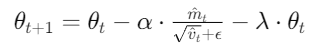

### CosineAnnealingLR
- Learning rate가 코사인 함수 주기에 따라 감소하고 증가한다. 

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fr9CJJ%2FbtriX9rt1XG%2Fa8uW9YF5Zm0LsIBnFaoAKK%2Fimg.png" width="50%"/>

Fold 0:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.923069, Valid Loss:   0.724359
Loss improves from        inf to   0.724359
Epoch 1
Train Loss:   0.664255, Valid Loss:   0.629559
Loss improves from   0.724359 to   0.629559
Epoch 2
Train Loss:   0.562615, Valid Loss:   0.617583
Loss improves from   0.629559 to   0.617583
Epoch 3
Train Loss:   0.500094, Valid Loss:   0.633246
Epoch 4
Train Loss:   0.447865, Valid Loss:   0.604507
Loss improves from   0.617583 to   0.604507
Epoch 5
Train Loss:   0.389341, Valid Loss:   0.638917
Epoch 6
Train Loss:   0.344269, Valid Loss:    0.69842
Epoch 7
Train Loss:   0.296675, Valid Loss:    0.88318
Epoch 8
Train Loss:   0.267250, Valid Loss:   0.791814
Epoch 9
Train Loss:   0.224898, Valid Loss:   0.712158

Best loss Model training with 0.6045066952705384



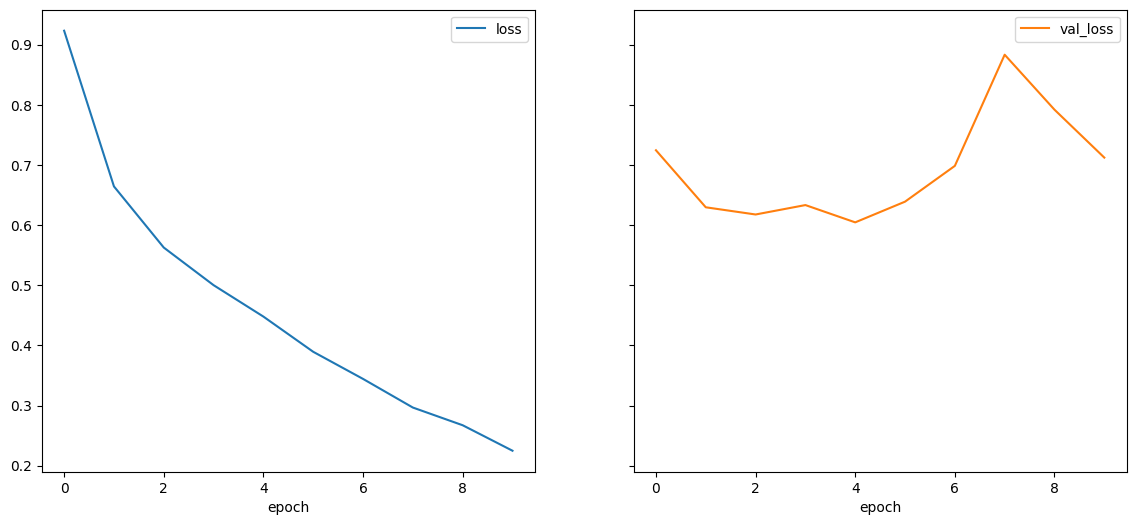

Fold 1:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.890724, Valid Loss:   0.765894
Loss improves from        inf to   0.765894
Epoch 1
Train Loss:   0.640723, Valid Loss:    0.62629
Loss improves from   0.765894 to    0.62629
Epoch 2
Train Loss:   0.554123, Valid Loss:    0.65238
Epoch 3
Train Loss:   0.498212, Valid Loss:   0.624255
Loss improves from   0.626290 to   0.624255
Epoch 4
Train Loss:   0.437870, Valid Loss:   0.650013
Epoch 5
Train Loss:   0.377503, Valid Loss:   0.630624
Epoch 6
Train Loss:   0.324238, Valid Loss:   0.732168
Epoch 7
Train Loss:   0.288440, Valid Loss:   0.722179
Epoch 8
Train Loss:   0.258438, Valid Loss:   0.707458
Epoch 9
Train Loss:   0.218018, Valid Loss:   0.737115

Best loss Model training with 0.6242548458278179



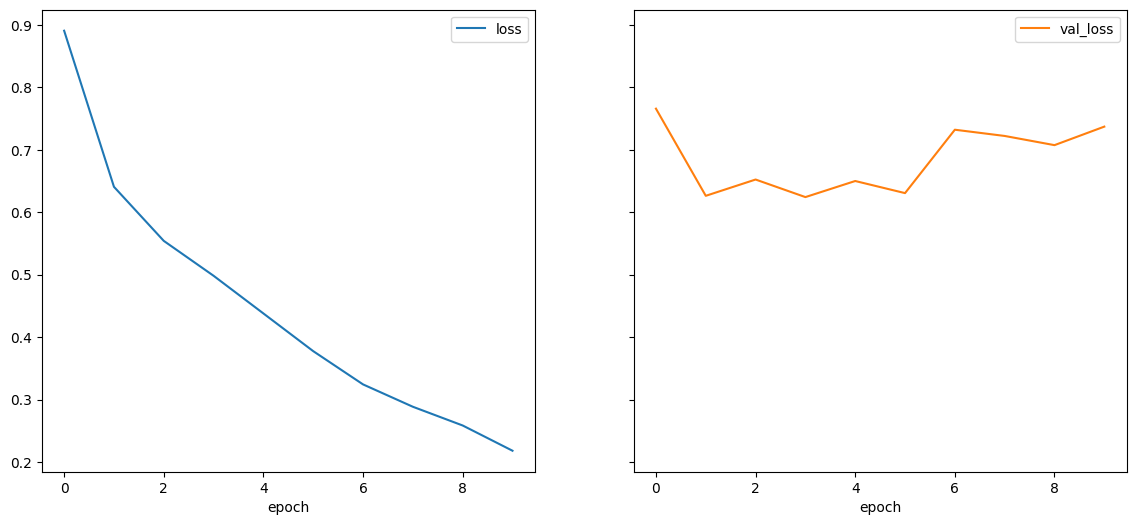

Fold 2:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.919267, Valid Loss:   0.792671
Loss improves from        inf to   0.792671
Epoch 1
Train Loss:   0.652935, Valid Loss:   0.631441
Loss improves from   0.792671 to   0.631441
Epoch 2
Train Loss:   0.558142, Valid Loss:   0.588802
Loss improves from   0.631441 to   0.588802
Epoch 3
Train Loss:   0.497696, Valid Loss:   0.592151
Epoch 4
Train Loss:   0.439769, Valid Loss:   0.622153
Epoch 5
Train Loss:   0.383591, Valid Loss:   0.629822
Epoch 6
Train Loss:   0.339764, Valid Loss:   0.704555
Epoch 7
Train Loss:   0.297722, Valid Loss:   0.588253
Loss improves from   0.588802 to   0.588253
Epoch 8
Train Loss:   0.249602, Valid Loss:   0.657698
Epoch 9
Train Loss:   0.225703, Valid Loss:    0.68701

Best loss Model training with 0.588252646795341



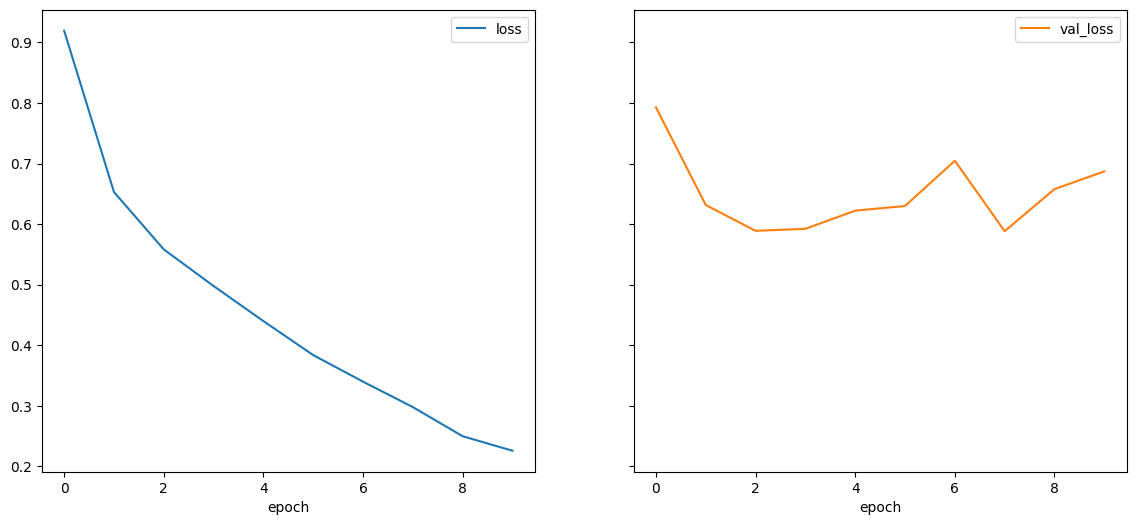

Fold 3:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.916792, Valid Loss:    0.70412
Loss improves from        inf to    0.70412
Epoch 1
Train Loss:   0.638395, Valid Loss:   0.604832
Loss improves from   0.704120 to   0.604832
Epoch 2
Train Loss:   0.553950, Valid Loss:   0.728161
Epoch 3
Train Loss:   0.504948, Valid Loss:   0.660723
Epoch 4
Train Loss:   0.439211, Valid Loss:   0.682509
Epoch 5
Train Loss:   0.383459, Valid Loss:   0.675133
Epoch 6
Train Loss:   0.326471, Valid Loss:   0.681298
Epoch 7
Train Loss:   0.281684, Valid Loss:   0.686799
Epoch 8
Train Loss:   0.248891, Valid Loss:   0.667795
Epoch 9
Train Loss:   0.213583, Valid Loss:    0.67583

Best loss Model training with 0.6048323668539524



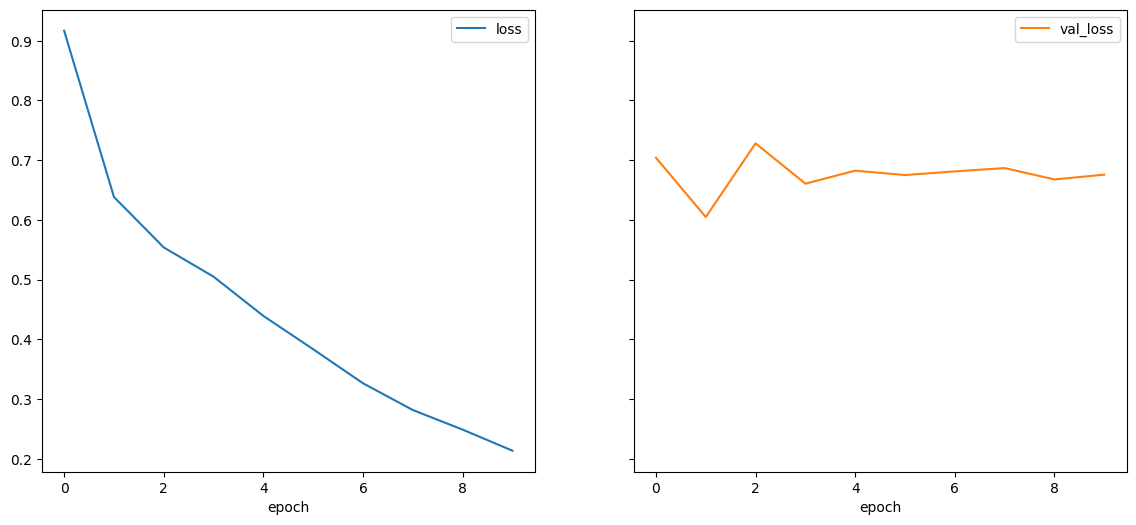

Fold 4:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.935900, Valid Loss:   0.686056
Loss improves from        inf to   0.686056
Epoch 1
Train Loss:   0.638662, Valid Loss:   0.599348
Loss improves from   0.686056 to   0.599348
Epoch 2
Train Loss:   0.552367, Valid Loss:   0.612588
Epoch 3
Train Loss:   0.488656, Valid Loss:   0.605343
Epoch 4
Train Loss:   0.440808, Valid Loss:   0.572867
Loss improves from   0.599348 to   0.572867
Epoch 5
Train Loss:   0.377543, Valid Loss:   0.644575
Epoch 6
Train Loss:   0.340148, Valid Loss:   0.629765
Epoch 7
Train Loss:   0.293957, Valid Loss:   0.655571
Epoch 8
Train Loss:   0.253701, Valid Loss:   0.646737
Epoch 9
Train Loss:   0.227738, Valid Loss:   0.697859

Best loss Model training with 0.572866662378822



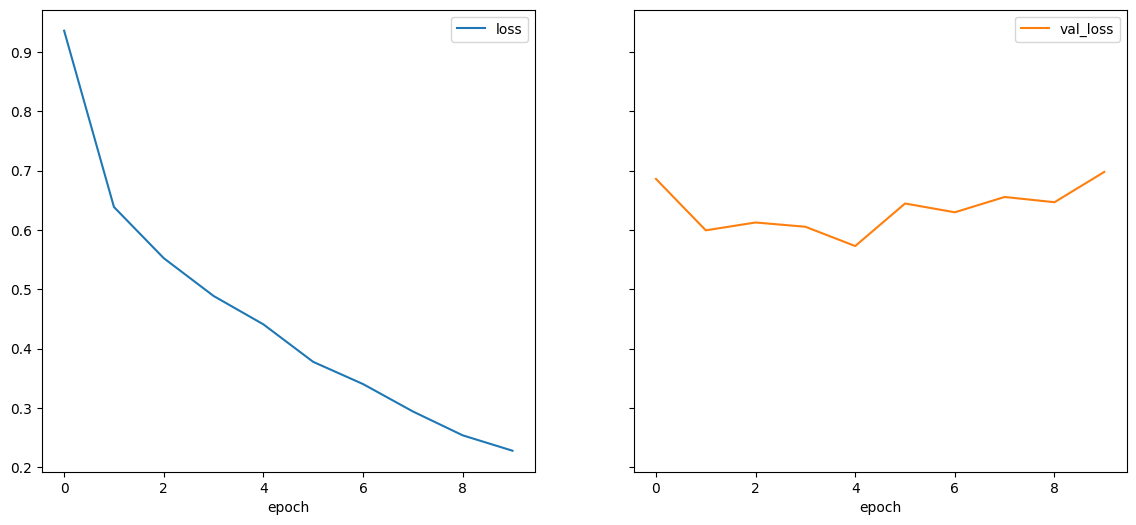

CPU times: user 2h 47min 10s, sys: 4min 47s, total: 2h 51min 57s
Wall time: 3h 36min 19s


In [28]:
%%time 

kf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed) # k-fold 기법 사용

l_best_loss = []
for fold, (iloc_train, iloc_valid) in enumerate(kf.split(data)):
    print(f"Fold {fold}:")

    # prepare data
    train_ds = SpecDataset(df=data.iloc[iloc_train])
    valid_ds = SpecDataset(df=data.iloc[iloc_valid])
    train_loader = DataLoader(dataset=train_ds, shuffle=True, batch_size=CFG.batch_size, num_workers=os.cpu_count(), drop_last=True)
    valid_loader = DataLoader(dataset=valid_ds, batch_size=CFG.batch_size, num_workers=os.cpu_count())
    
    # init training
    model = timm.create_model(model_name=CFG.model_name, pretrained=True, num_classes=6, in_chans=1)
    model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr) # optimizer: AdamW
    scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG.epochs) # learning rate scheduler
    optimizer, scheduler
    best_loss = float("inf")
    history = []
    
    # run training
    for epoch in tqdm(range(CFG.epochs)):
        model.train()
        l_loss = []
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred = model(x)
            loss = KLDivLoss(y_pred, y)
            l_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss = np.mean(l_loss)
        valid_loss = compute_loss(model, valid_loader)
        history.append((epoch, train_loss, valid_loss))
        print(f"Epoch {epoch}")
        print(f"Train Loss: {train_loss:>10.6f}, Valid Loss: {valid_loss:>10.6}")
        if valid_loss < best_loss:
            print(f"Loss improves from {best_loss:>10.6f} to {valid_loss:>10.6}")
            torch.save(model.state_dict(), f"{CFG.model_name}__{fold}.pt")
            best_loss = valid_loss
    print(f"\nBest loss Model training with {best_loss}\n")
    l_best_loss.append(best_loss)
    
    # plot
    history = pd.DataFrame(history, columns=["epoch", "loss", "val_loss"]).set_index("epoch")
    history.plot(subplots=True, layout=(1, 2), sharey="row", figsize=(14, 6))
    plt.show()
    
    if CFG.one_fold:
        break

# OOF

In [29]:
l_best_loss, np.mean(l_best_loss)

([0.6045066952705384,
  0.6242548458278179,
  0.588252646795341,
  0.6048323668539524,
  0.572866662378822],
 0.5989426434252944)

In [30]:
PATH = '/kaggle/'
torch.save(model.state_dict(), PATH + 'model_tf_efficientnet_b0_ns_CosineAnnealingLR_schedule_with_adamW_.pth')  # 모델 객체의 state_dict 저장
model.load_state_dict(torch.load(PATH + 'model_tf_efficientnet_b0_ns_CosineAnnealingLR_schedule_with_adamW_.pth'))

<All keys matched successfully>